In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
device = ("cuda" if torch.cuda.is_available()
    else "mps"   if torch.backends.mps.is_available()
    else "cpu")
print(f"Using {device} device")

Using mps device


In [3]:
# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 10),
            nn.Tanh(),
            nn.Linear(10, 1),
        )

    def forward(self, x):
        #x = self.flatten(x)
        output = self.linear_tanh_stack(x)
        return output

In [4]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_tanh_stack): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [5]:
# Function that I want to approximate with the neural network
def myFun(x1, x2):
    f = x1 * np.exp(-x1**2-x2**2)
    return f
    
# Generate training and test data sets
Ntrain = 500
X_train = 4 * np.random.rand(2, Ntrain).astype("float32") - 2

Ntest = 100
X_test = 4 * np.random.rand(2, Ntest).astype("float32") - 2

Y_train = np.zeros(Ntrain, dtype="float32")
for i in range(Ntrain):
    Y_train[i] = myFun(X_train[0,i],X_train[1,i])

Y_test = np.zeros(Ntest, dtype="float32")
for i in range(Ntest):
    Y_test[i] = myFun(X_test[0,i],X_test[1,i])


In [6]:
# Hyperparameters
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
learning_rate = 1e-3
epochs = 5000
# Initialize the loss function
loss_fn = nn.MSELoss(reduction='sum')
# Optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
X_train_tensor = torch.from_numpy(X_train).to(device)
Y_train_tensor = torch.from_numpy(Y_train).to(device)
X_test_tensor = torch.from_numpy(X_test).to(device)
Y_test_tensor = torch.from_numpy(Y_test).to(device)
loss_hist = np.array([])
loss_test_hist = np.array([])
for t in range(epochs):
    model.train()
    pred = model(X_train_tensor.T)
    loss = loss_fn(pred.flatten(), Y_train_tensor)
    with torch.no_grad():
        pred_test = model(X_test_tensor.T)
        loss_test = loss_fn(pred_test.flatten(), Y_test_tensor)
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if t % 500 == 0:
        print(f"iter: {t:>3d}   loss: {loss:>7f} loss for test: {loss_test:>7f}")
    loss_hist = np.append(loss_hist, loss.cpu().detach().numpy())
    loss_test_hist = np.append(loss_test_hist, loss_test.cpu().detach().numpy())
print("Done!")

iter:   0   loss: 28.709675 loss for test: 5.225615
iter: 500   loss: 0.429683 loss for test: 0.084535
iter: 1000   loss: 0.098815 loss for test: 0.021332
iter: 1500   loss: 0.065844 loss for test: 0.013739
iter: 2000   loss: 0.052426 loss for test: 0.011236
iter: 2500   loss: 0.040837 loss for test: 0.008943
iter: 3000   loss: 0.029055 loss for test: 0.006463
iter: 3500   loss: 0.017053 loss for test: 0.003783
iter: 4000   loss: 0.008722 loss for test: 0.001852
iter: 4500   loss: 0.005001 loss for test: 0.001099
Done!


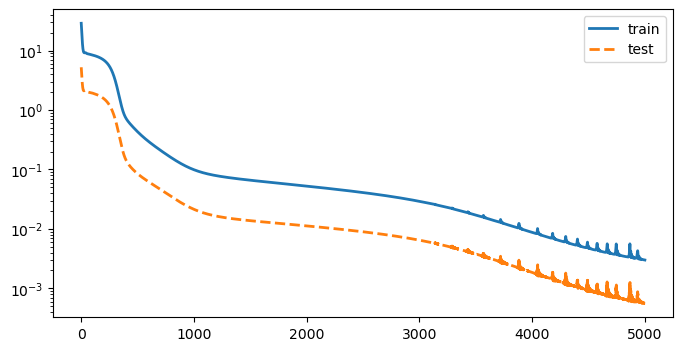

In [8]:
from matplotlib import pyplot as plt
from matplotlib import cm

plt.figure(figsize=(8, 4))
plt.plot(loss_hist, linewidth=2)
plt.plot(loss_test_hist, linestyle='dashed', linewidth=2)
plt.yscale("log")
plt.legend({"train", "test"})

In [9]:
X = np.arange(-2, 2, 0.1).astype("float32")
Y = np.arange(-2, 2, 0.1).astype("float32")
Xplot, Yplot = np.meshgrid(X, Y)
Zplot = myFun(Xplot, Yplot) 

In [10]:
with torch.no_grad():
    Xplot_tensor = torch.from_numpy(Xplot).to(device)
    Yplot_tensor = torch.from_numpy(Yplot).to(device)
    Zplot_NN = torch.zeros(Xplot.shape, device=device)
    cols,rows = Xplot_tensor.shape
    for i in range(rows):
        for j in range(cols):
            Zplot_NN[i,j] = model(torch.tensor([ Xplot_tensor[i,j],Yplot_tensor[i,j] ], device=device))

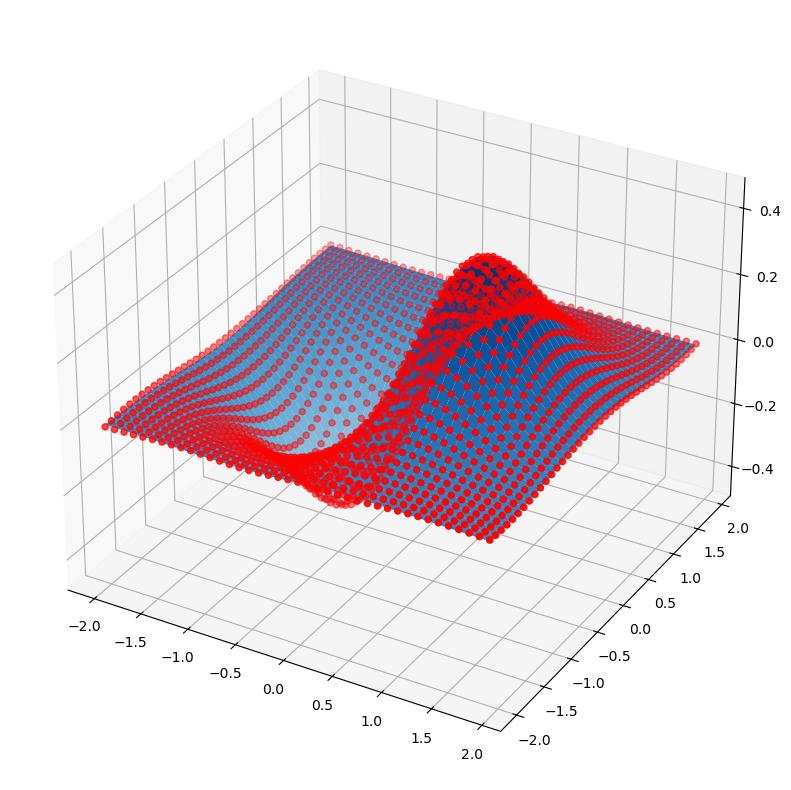

In [11]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
ax.plot_surface(Xplot, Yplot, Zplot, vmin=Zplot.min() * 2, cmap=cm.Blues)
ax.scatter(Xplot, Yplot, Zplot_NN.cpu().numpy(), marker='o', color='red')